# validating data

finding Valid Data (images)


In [ ]:
import os
import cv2
import shutil

# Define your train folder, valid folder, and fixed size
train_folder = "/mnt/AA0066EF0066C1C5/Internship/plant /Train"
valid_folder = "/mnt/AA0066EF0066C1C5/Internship/plant /Valid"
fixed_size = (256, 256)  # Adjust the size as needed

# Create the "Valid" folder if it doesn't exist
if not os.path.exists(valid_folder):
    os.makedirs(valid_folder)

# Function to check if an image is valid (customize this according to your criteria)
def is_valid_image(image_path):
    try:
        image = cv2.imread(image_path)
        # Example validity check: you can add your custom criteria here.
        return image is not None and image.shape[0] > 0 and image.shape[1] > 0
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return False

# Get a list of all class folders in the train folder
class_folders = [folder for folder in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, folder))]

# Iterate through all class folders
for class_folder in class_folders:
    class_train_folder = os.path.join(train_folder, class_folder)
    class_valid_folder = os.path.join(valid_folder, class_folder)

    # Create the class folder in the "Valid" directory
    os.makedirs(class_valid_folder, exist_ok=True)

    # Iterate through all images in the class folder
    for root, _, files in os.walk(class_train_folder):
        for image_filename in files:
            if image_filename.endswith(".jpg"):  # Adjust the file format as needed
                image_path = os.path.join(root, image_filename)
                if is_valid_image(image_path):
                    # Read and resize the image to the fixed size
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, fixed_size)

                    # Get the relative path of the image within the class folder
                    relative_path = os.path.relpath(image_path, class_train_folder)

                    # Construct the destination path in the valid folder
                    destination_path = os.path.join(class_valid_folder, relative_path)

                    # Create the directory structure if it doesn't exist
                    os.makedirs(os.path.dirname(destination_path), exist_ok=True)

                    # Save the resized image to the "Valid" folder
                    cv2.imwrite(destination_path, image)


# Importing data to Program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow
import tensorflow.keras as keras
from keras.applications.vgg19 import VGG19 , preprocess_input ,decode_predictions
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

train_datagen=ImageDataGenerator(zoom_range= 0.5, shear_range= 0.3, horizontal_flip= True,preprocessing_function=preprocess_input)
val_datagen =ImageDataGenerator(preprocessing_function=preprocess_input)
train=train_datagen.flow_from_directory(directory="/mnt/AA0066EF0066C1C5/Internship/plant /Train",target_size=(256,256),batch_size=32)
val=train_datagen.flow_from_directory(directory="/mnt/AA0066EF0066C1C5/Internship/plant /Valid",target_size=(256,256),batch_size=32)

2023-10-05 00:53:25.903270: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 00:53:25.960409: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-05 00:53:25.960457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-05 00:53:25.960526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 00:53:25.975410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 00:53:25.976227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Found 54305 images belonging to 38 classes.
Found 1500 images belonging to 38 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


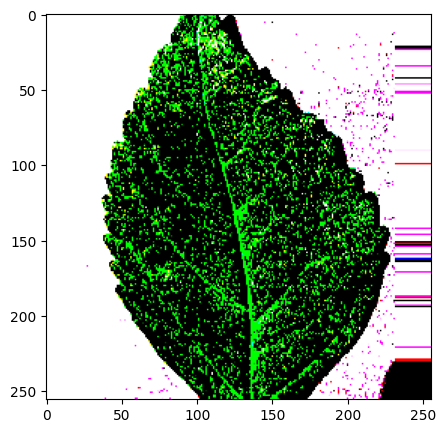

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


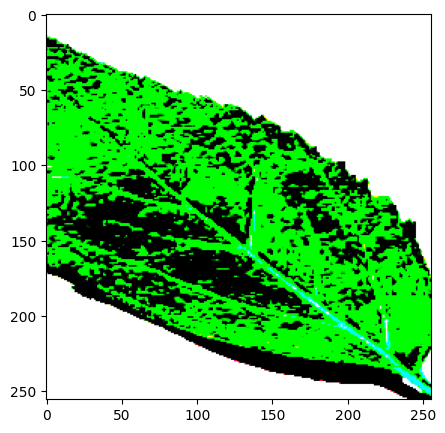

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


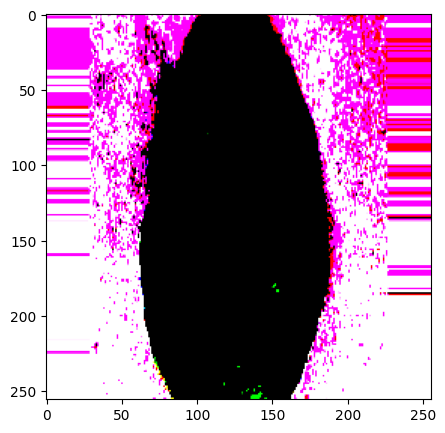

In [5]:
t_img , label = train.next()

def plottaage(img_arr, Label):


    for im , l in zip(img_arr , label):
        plt. figure(figsize=(5,5))
        plt.imshow(im)
        plt.show()

 
plottaage(t_img[:3], label[:3])

# Building our Model


In [2]:
from keras.layers import Dense,Flatten
import scipy
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

base_model=VGG19(input_shape=(256,256,3),include_top=False)


for layers in base_model.layers:
    layers.trainable=False
# base_model.summary()
X=Flatten()(base_model.output)

X=Dense(units=38,activation="softmax")(X)

# creating model
model=Model(base_model.input,X)

# model.summary()

model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy']) 

# Early Stopping and MOdel checkpoint

only run once when the Model is not created


In [ ]:
from keras.callbacks import EarlyStopping ,ModelCheckpoint
# early stopping 
er=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
#Model check point
mc = ModelCheckpoint(filepath='best_model.h',monitor='val_accuracy',
                     min_delta=0.01,patience=3,verbose=1,
                     save_best_only=True)


cb=[er,mc]
his = model.fit_generator(train ,
steps_per_epoch= 16,
epochs= 50,
verbose= 1,
callbacks= cb ,
validation_data= val ,
validation_steps= 16 )




# Loading My MOdel


In [3]:

#load our model 
from keras.models import load_model
model=load_model("/mnt/AA0066EF0066C1C5/Internship/plant /best_model.h")
ref= dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

# making GUI

In [7]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf
current_image = None

def open_image():
    global current_image
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        image.thumbnail((300, 300))
        photo = ImageTk.PhotoImage(image)
        label.config(image=photo)
        label.image = photo
        current_image = image  # Store the currently opened image

def detect_disease():
    global current_image
    if current_image is not None:
        # Resize the image to the model's input size
        img = current_image.resize((256, 256))

        # Convert to NumPy array and normalize
        img_array = np.array(img)
        img_array = img_array / 255.0

        # Expand dimensions to match the model's input shape
        img_array = np.expand_dims(img_array, axis=0)

        # Make predictions using the loaded model
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions)

        # Get the predicted class label
        predicted_class = ref.get(class_index, "Unknown")

        # print(f"The image belongs to the class: {predicted_class}")
        result_label.config(text=f"Detected Disease: {predicted_class}")
    else:
        print("Please open an image first.")

# Create the main window
window = tk.Tk()
window.title("Plant Disease Detection")

# Create widgets
open_button = tk.Button(window, text="Open Image", command=open_image)
detect_button = tk.Button(window, text="Detect Disease", command=detect_disease)
label = tk.Label(window)
result_label = tk.Label(window, text="Detected Disease: ")

# Layout widgets
open_button.pack()
detect_button.pack()
label.pack()
result_label.pack()

window.mainloop()


1/1 [==============================] - 0s 221ms/step
